In [1]:
%load_ext autoreload
%autoreload 2

# Using Jupyter widgets to explore simple queueing models in Python

In the [previous module in which we learned how to do discrete event simulation modeling with SimPy](http://www.sba.oakland.edu/faculty/isken/courses/mis6900/mod4_des_simpy.html), we explored a model of a vaccine clinic. Systems like that in which entities contend and wait for limited resources are known as queueing systems. There's a huge branch of applied math known as [queueing theory](https://en.wikipedia.org/wiki/Queueing_theory) in which models of such systems are built and analyzed. There are many, many different queueing models with some being relatively simple and some being horribly complex. It all depends on the assumptions made about the system being modeled. Such models often can't capture the intricate details that a simulation model can, but, they are often quite useful for rough approximations and are much faster than simulation models - they are often just formulas or simple numerical computations. 

In this notebook, we'll create interactive plots using [Jupyter widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html) to allow us to explore a simple queueing model of part of the vaccine clinic - just the vaccination stage.

Some of my research involves queueing models and I've coded up a bunch of Python functions for computing various performance measures a number of common queueing systems. We'll use a few of those functions to start to learn to use `ipywidgets`. The two basic queueing models we'll explore are the $M/M/c$ and $M/G/c$ queueing systems ([Kendall's notation is shorthand for describing such systems](https://en.wikipedia.org/wiki/Kendall%27s_notation)). These models (and their numerous variants) have been used extensively in customer service systems such as call centers and hospitals.

**$M/M/c/\infty$ - multiserver Markovian (exponential distribution) queue**

- Poisson arrivals (exponentially distributed interarrival times) - the first "M",
- exponential service - the second "M",
- c servers,
- unlimited queue size,
- arrivals finding all servers busy join the FCFS queue to wait for an available server

**$M/G/c/\infty$ - multiserver queue**

- Poisson arrivals (exponentially distributed interarrival times)
- general service time distribution
- c servers
- unlimited queue size
- arrivals finding all servers busy join the FCFS queue to wait for an available server

A special case of the model above is:

**$M/G/c/c$ - Erlang loss system**

- Poisson arrivals (exponentially distributed interarrival times)
- general service time distribution - the "G"
- c servers
- no queueing allowed (the second c in $M/G/c/c$ is the total number of customers allowed in system (service + queue)
- arrivals finding all servers busy are lost to the system

## Preliminaries
Do some magic and import some libraries.

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

Here is the import of queueing library I created.

In [4]:
import qng as q

Here are the imports needed for the widgets.

In [5]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed
from IPython.display import display

## Functions to compute performance measures

The `qng.py` library has numerous functions related to queueing model performance measures. We'll just be using the following:

* `erlangc` - computes the probability that an arrival to an $M/M/c/\infty$ system finds the system full and has to wait in queue for an available server
* `mmc_mean_qwait` - computes the mean wait time in queue for an $M/M/c/\infty$ system
* `mgc_mean_qwait_kimura` - computes the approximate mean wait time for an $M/G/c$ system
* `mmc_qwait_cdf` - computes the probability of wait time in queue being less than some time, $t$, in an $M/M/c/\infty$ system
* `mgc_qwait_cdf_whitt1` - computes the approximate probability of wait time in queue being less than some time, $t$, in an $M/G/c/\infty$ system
* `erlangb` - computes the probability that an arrival to an $M/G/c/c$ system finds the system full and is lost

Both the [Erlang-B](https://en.wikipedia.org/wiki/Erlang_%28unit%29#Erlang_B_formula) and [Erlang-C](https://en.wikipedia.org/wiki/Erlang_%28unit%29#Erlang_C_formula) are well known queueing formulas and have efficient computational implementations.

You might have noticed that for the $M/G/c/\infty$ related functions, the computed performance measures are approximations. For the $M/M/c/\infty$ related functions, the formulas are exact. Why? Well..., it turns out that the exponential distribution (the $M$'s) leads to much more tractable analysis - the *memoryless property* is the key. Simply generalizing from exponential service ($M/M/c$) to a general service time distribution ($M/G/c$) leads to math that even after close to 100 years of queueing theory developments has not yielded exact results. Nevertheless, researchers have come up with very clever and very accurate approximations. We will be using several such approximations.



Here's a quick plot of the Erlang-C function for an $M/M/1$ system and a range of traffic intensities. A few things to note:

- Usually we represent the arrival rate by the greek letter $\lambda$. It's the average number of customer arrivals per unit time.
- Each server can process arrivals at a rate $\mu$. So, $\frac{1}{\mu}$ is the average amount of time that a customer spends in the system.
- The *traffic intensity*, usually denoted by the greek letter rho ($\rho$), is the ratio of the customer arrival rate, $\lambda$, to the system's overall service rate, $c\mu$. 
- The *load*  is $c\rho$ where $c$ is the number of servers and the units are known as *erlangs*,
- For $M/M/c$ systems to be stable and to be able to compute the Erlang-C function, we need $\rho < 1$ (traffic intensities greater than 1 are ok for $M/G/c/c$ but you'll just get more and more customers being lost).

In [6]:
help(q.erlangc)

Help on function erlangc in module qng:

erlangc(load, c)
    Return the the probability of delay in M/M/c/inf system using recursive Erlang B approach.
    
    
    Parameters
    ----------
    load : float
        average arrival rate * average service time (units are erlangs)
    c : int
        number of servers
    
    Returns
    -------
    float
        probability all servers busy



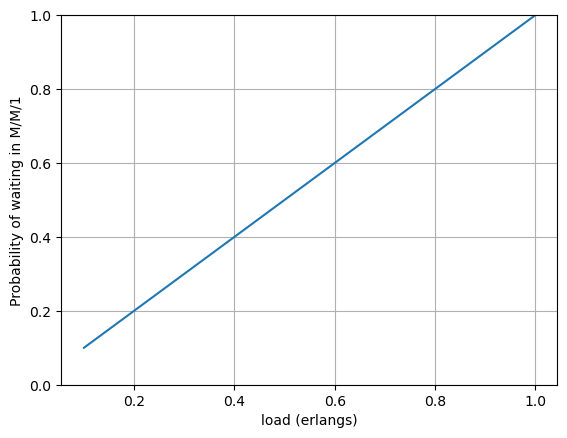

In [7]:
rho = np.linspace(0.1, .999, 50)
c = 1
q_prob_wait = [q.erlangc(r * c, c) for r in rho]
plt.plot(rho, q_prob_wait)
plt.ylim(0, 1.0)
plt.xlabel('load (erlangs)')
plt.ylabel(f'Probability of waiting in M/M/{c}')
plt.grid()
plt.show()

In [8]:
help(q.mmc_mean_qwait)

Help on function mmc_mean_qwait in module qng:

mmc_mean_qwait(arr_rate, svc_rate, c)
    Return the the mean wait in queue time in M/M/c/inf queue.
    
    Uses mmc_mean_qsize along with Little's Law.
    
    Parameters
    ----------
    arr_rate : float
        average arrival rate to queueing system
    svc_rate : float
        average service rate (each server). 1/svc_rate is mean service time.
    c : int
        number of servers
    
    Returns
    -------
    float
        mean wait time in queue



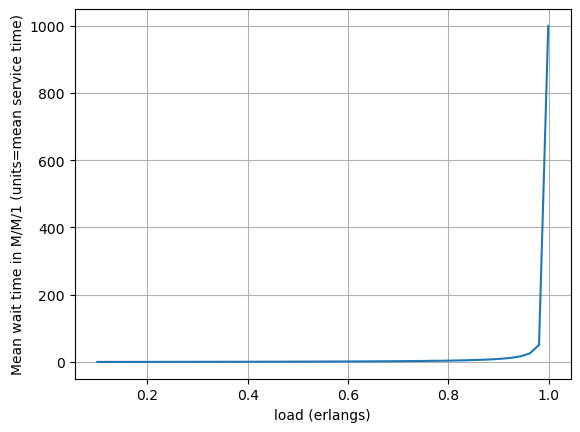

In [9]:
rho = np.linspace(0.1, .999, 50)
service_rate = 1.0
c = 1
q_mean_wait = [q.mmc_mean_qwait(r * c, service_rate, c) for r in rho]
plt.plot(rho, q_mean_wait)
plt.xlabel('load (erlangs)')
plt.ylabel(f'Mean wait time in M/M/{c} (units=mean service time)')
plt.grid()
plt.show()

Notice how the mean wait is small for a wide range of load values but increases exponentially as the load approaches 1.0. Now, let's add a line for a $M/M/13$ system. and just focus on high levels of $\rho$.

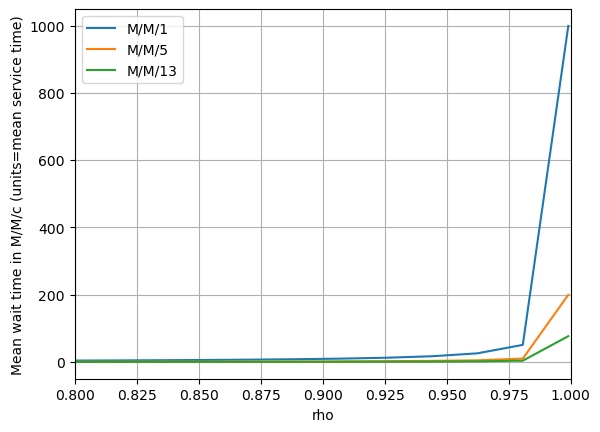

In [10]:
rho = np.linspace(0.1, .999, 50)
service_rate = 1.0
c = 1
q_mean_wait_1 = [q.mmc_mean_qwait(r * 1, service_rate, 1) for r in rho]
q_mean_wait_5 = [q.mmc_mean_qwait(r * 5, service_rate, 5) for r in rho]
q_mean_wait_13 = [q.mmc_mean_qwait(r * 13, service_rate, 13) for r in rho]
plt.plot(rho, q_mean_wait_1, label='M/M/1')
plt.plot(rho, q_mean_wait_5, label='M/M/5')
plt.plot(rho, q_mean_wait_13, label='M/M/13')
plt.xlim(0.8, 1.0)
plt.xlabel('rho')
plt.ylabel(f'Mean wait time in M/M/c (units=mean service time)')
plt.legend()
plt.grid()
plt.show()

This illustrates the economies of scale present in queueing systems. It's not surprising that large call centers are the norm. 

Even for traffic intensities very close to 1.0, the probability that an arriving customer finds the system full is less than 0.5. Let's let the traffic intensity exceed 1.0 (i.e. arrivals showing up on average faster than we can serve them).

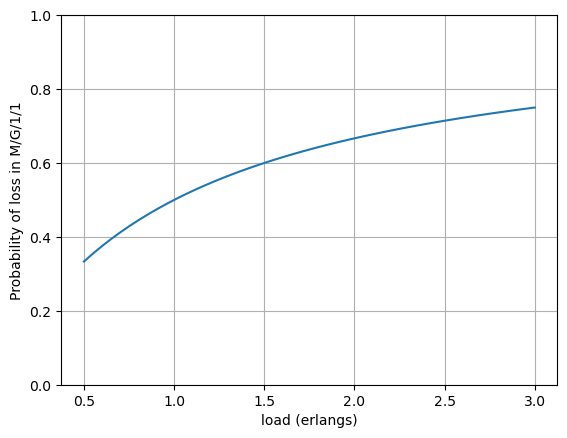

In [11]:
rho = np.linspace(0.5, 3, 50)
c = 1
plt.plot(rho, q.erlangb(rho * c,c))
plt.ylim(0, 1.0)
plt.xlabel('load (erlangs)')
plt.ylabel(f'Probability of loss in M/G/{c}/{c}')
plt.grid()
plt.show()

## Getting started with `ipywidgets`
Go check out the [Jupyter Widgets User Guide](http://ipywidgets.readthedocs.io/en/latest/index.html) to familiarize yourself with the basics of widgets. Let's use widgets to control the number of servers and the patient arrival rate. In our vaccine clinic simulation, we used the following parameters:

* $\lambda = 3$ patients per minute
* mean vaccination time = 4.0 minutes
* standard deviation of vaccination time = 0.5 minutes

Let's start by creating an `IntSlider` widget that lets the user pick the number of servers. The arguments are pretty self-explanatory.

In [12]:
arrival_rate = 3.0
service_time_mean = 4.0
service_time_sd = 0.5

In [13]:
# Create the integer slider object

# Need this style line to avoid description getting truncated
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
style = {'description_width': 'initial'}

pick_c = widgets.IntSlider(
    value=12,
    min=math.ceil(arrival_rate * service_time_mean),
    max=5 * math.ceil(arrival_rate * service_time_mean),
    step=1,
    style=style,
    description='Number of servers'
)

To show the slider, we can use the `display`function from the `IPython.display` module. Try it out.

In [14]:
display(pick_c)

IntSlider(value=12, description='Number of servers', max=60, min=12, style=SliderStyle(description_width='init…

Our goal is to somehow have such a slider interact with our queueing related functions. We want to call a function and pass in the slider value as an argument. As a simple example, consider the following function.

In [15]:
def f(x):
    print(x ** 2)

In [16]:
f(5)

25


To "hook up" the slider to the function, use the [`interact` function](http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html). A few things to note:

- The function is passed in as the first argument.
- The second argument to `interact` is a named argument which references the widget we want to use.
- We can pass a widget variable we've already created or create one on the fly.

In [17]:
interact(f, x=widgets.IntSlider(min=1, max=50, step=1, 
                                value=5, style=style,
                                description='Number to square'));

interactive(children=(IntSlider(value=5, description='Number to square', max=50, min=1, style=SliderStyle(desc…

Put all these ideas together and we end up with an interactive plot showing how the mean wait time in an $M/M/c$ system function varies across a range of arrival rates for a given number of servers.

In [18]:
# Create function to generate plot based on erlang-b and slider controlling number of servers
def mmc_meanwait_plot(num_servers):
    plt.figure(1)
    arrival_rates = np.linspace(1, 5, 10)
    q_mean_wait = [q.mmc_mean_qwait(arr, 1 / 4.0, num_servers) for arr in arrival_rates]
    plt.plot(arrival_rates, q_mean_wait)
    plt.xlabel('Patients per hour')
    plt.ylabel('Mean wait time in M/M/c/infinity')
    plt.grid()
    plt.show()

# Create a widget for the number of servers
c_1 = widgets.IntSlider(
    value=5,
    min=13,
    max=50,
    step=1,
    style=style,
    description='Number of servers'
)

# Create an interactive element and hook the slider to the erlang-b function
interact(mmc_meanwait_plot, num_servers=c_1);

interactive(children=(IntSlider(value=13, description='Number of servers', max=50, min=13, style=SliderStyle(d…

Let's include both Erlang-B and C on this plot. Notice also that instead of `interact`, we are using `interactive`. The `interactive` function returns an interactive widget object that can then be modified or interrogated (e.g., to get the values passed in). See the [docs](http://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html) for more details.

In [21]:
def erlangc_pwaitplot(num_servers):
    plt.figure(2)
    rho = np.linspace(0.5, .999, 50)
    plt.plot(rho, q.erlangc(rho * num_servers, num_servers), label='P[Wait>0] in M/M/c')
    plt.plot(rho, q.erlangb(rho * num_servers, num_servers), label='P[loss] in M/G/c/c')
    plt.ylim(0, 1.0)
    plt.xlabel('rho')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()
    plt.show()

c_2 = widgets.IntSlider(
    value=5,
    min=1,
    max=50,
    step=1,
    style=style,
    description=r'Number of servers'
)

# Instead of interact, we'll use interactive so that we can reuse the interactive object
# and set some of its properties (height of layout area in this case).
interactive_plot_c = interactive(erlangc_pwaitplot, num_servers=c_2)
interactive_plot_c.layout.height = '500px'
interactive_plot_c

interactive(children=(IntSlider(value=5, description='Number of servers', max=50, min=1, style=SliderStyle(des…

Another useful widget allows the user to select a range via a slider. Let's try it out for selecting the range of traffic intensities. Start out by creating a `FloatRangeSlider` object and then displaying it. Try it out. Note the use of LaTex in the description.

In [22]:
rho_range = widgets.FloatRangeSlider(
    value=[0.5, .99],
    min=0.01,
    max=0.99,
    step=0.01,
    description=r'Range for \(\rho \)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

In [23]:
display(rho_range)

FloatRangeSlider(value=(0.5, 0.99), continuous_update=False, description='Range for \\(\\rho \\)', max=0.99, m…

In [24]:
# Print out the key slider property values
print(rho_range.lower, rho_range.upper)
# The value property of the slider is a tuple containing the lower and upper range choices.
print(rho_range.value)

0.5 0.99
(0.5, 0.99)


Create function that takes both widgets as inputs.

In [25]:
def erlangc_pwaitplot2(num_servers, rho_range):
    plt.figure(3)
    rho = np.linspace(rho_range[0], rho_range[1], 50)
    plt.plot(rho, q.erlangc(rho * num_servers, num_servers), label='Prob of wait: $P(W>0)$ in M/M/c')
    plt.plot(rho, q.erlangb(rho * num_servers, num_servers), label='Prob of loss: $P(N=c)$ in M/G/c/c')
    plt.ylim(0, 1.0)
    plt.xlabel('load (erlangs)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()
    plt.show()

interactive_plot_rhorange = interactive(erlangc_pwaitplot2, num_servers=c_2, rho_range=rho_range)
interactive_plot_rhorange

interactive(children=(IntSlider(value=5, description='Number of servers', max=50, min=1, style=SliderStyle(des…

## System Dimensioning
Finally, let's use both models for simple "dimensioning" by choosing the number of servers such that some specified *overflow threshold* on the loss probability (for $M/G/c/c$) or probability of waiting (for $M/M/c$). We'll use both `Text` widgets and a few different container widgets.

We'll use a `FloatSlider` for the overflow threshold and for the load placed on the system.

In [26]:
overflow_threshold_slider = widgets.FloatSlider(
    value=0.05,
    min=0.01,
    max=0.25,
    step=0.01,
    style=style,
    description='Overflow threshold'
)

load_slider = widgets.FloatSlider(
    value=5.0,
    min=0.0,
    max=50,
    step=0.5,
    style=style,
    description='Load'
)

Here's are two "inverse" functions that return the number of servers needed to serve a given load and meet a specified overflow probability threshold.

In [27]:
def erlangc_inv(prob, load):
    """
    Return the number of servers such that probability of delay in M/M/c/inf system is
    less than specified probability


    Parameters
    ----------
    prob : float
        threshold delay probability
    load : float
        average arrival rate * average service time (units are erlangs)

    Returns
    -------
    c : int
        number of servers

    """

    c = math.ceil(load)
    ec = q.erlangc(load, c)
    if ec <= prob:
        return c
    else:
        while ec > prob:
            c += 1
            ec = q.erlangc(load, c)

    return c

def erlangb_inv(prob, load):
    """
    Return the number of servers such that probability of loss in an M/G/c/c system is
    less than specified probability


    Parameters
    ----------
    prob : float
        threshold loss probability
    load : float
        average arrival rate * average service time (units are erlangs)

    Returns
    -------
    c : int
        number of servers

    """

    c = math.ceil(load)
    ec = q.erlangb(load, c)
    if ec <= prob:
        return c
    else:
        while ec > prob:
            c += 1
            ec = q.erlangc(load, c)

    return c

There are several different text related widgets.

In [28]:

widgets.Text(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)

Text(value='Hello World', description='String:', placeholder='Type something')

We'll use `IntText` widgets for displaying integer values corresponding to the number of servers needed. Note that we are setting `disabled=True` as we won't be using these text boxes for input but simply for output display.

In [29]:
b_out = widgets.IntText(
            value=0,
            description='Servers for M/G/c/c:',
            style=style,
            disabled=True
        )

c_out = widgets.IntText(
            value=0,
            description='Servers for M/M/c:',
            style=style,
            disabled=True
        )

Before trying to get the output text boxes working, let's just test out a function for calling the inverse functions.

In [30]:
def dimensioner1(load, threshold):
        b = erlangb_inv(threshold, load)
        c = erlangc_inv(threshold, load)
        
        print(b,c)

In [31]:
interact(dimensioner1, load=load_slider, threshold=overflow_threshold_slider);


interactive(children=(FloatSlider(value=5.0, description='Load', max=50.0, step=0.5, style=SliderStyle(descrip…

Now, instead of printing the two server values, let's set the value property of our `IntText` widgets and then display them.

In [32]:
def dimensioner2(load, threshold):
        b = erlangb_inv(threshold, load)
        c = erlangc_inv(threshold, load)
        
        b_out.value = b
        c_out.value = c
        

In [33]:
display(b_out)
display(c_out)

IntText(value=0, description='Servers for M/G/c/c:', disabled=True, style=DescriptionStyle(description_width='…

IntText(value=0, description='Servers for M/M/c:', disabled=True, style=DescriptionStyle(description_width='in…

Now set up the interactive sliders. Try them out and watch what happens to the text boxes above.

In [34]:
interact(dimensioner2, load=load_slider, threshold=overflow_threshold_slider);

interactive(children=(FloatSlider(value=11.0, description='Load', max=50.0, step=0.5, style=SliderStyle(descri…

Let's enhance the output by also computing and displaying the actual loss and wait probabilities associated with the numbers of servers returned by the inverse functions.

In [35]:
b_prob_out = widgets.Text(
            value='0.0',
            description='P[loss] in M/G/c/c:',
            style=style,
            disabled=True
        )

c_prob_out = widgets.Text(
            value='0.0',
            description='P[wait] in M/M/c:',
            style=style,
            disabled=True
        )

In [36]:
def dimensioner3(load, threshold):
        b = erlangb_inv(threshold, load)
        c = erlangc_inv(threshold, load)
        
        b_prob = q.erlangb(load, b)
        c_prob = q.erlangc(load, c)
        
        b_out.value = b
        c_out.value = c
        
        b_prob_out.value = '{:.4f}'.format(b_prob)
        c_prob_out.value = '{:.4f}'.format(c_prob)        

We can use `VBox` and `HBox` widgets to create a simple rectangular layout of text boxes. Finally, we'll create the interactive widgets.

In [37]:
left_box = widgets.VBox([b_out, b_prob_out])
right_box = widgets.VBox([c_out, c_prob_out])
widgets.HBox([left_box, right_box])

In [38]:
interact(dimensioner3, load=load_slider, threshold=overflow_threshold_slider);

interactive(children=(FloatSlider(value=14.5, description='Load', max=50.0, step=0.5, style=SliderStyle(descri…

We've barely scratched the surface of what is possible with Jupyter widgets. 